# 2025-10-29 Nonlinear Regression

* Nonlinear models

* Computing derivatives

    * analytically (by hand)

    * numerically
 
    * algorithmically (automatic differentiation)

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# A utility for evaluating our regression
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Gradient descent

Instead of solving the least squares problem using linear algebra (QR factorization), we could solve it using gradient descent.
That is, on each iteration, we'll take a step in the direction of the negative gradient.

In [2]:
function grad_descent(loss, grad, c0; gamma=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess c0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    c = copy(c0)
    chist = [copy(c)]
    lhist = [loss(c)]
    for it in 1:500
        g = grad(c)
        c -= gamma * g
        push!(chist, copy(c))
        push!(lhist, loss(c))
        if norm(g) < tol
            break
        end
    end
    (c, hcat(chist...), lhist)
end

grad_descent (generic function with 1 method)

Gradient descent shows quadratic convergence.

cond(A) = 9.465784928823188


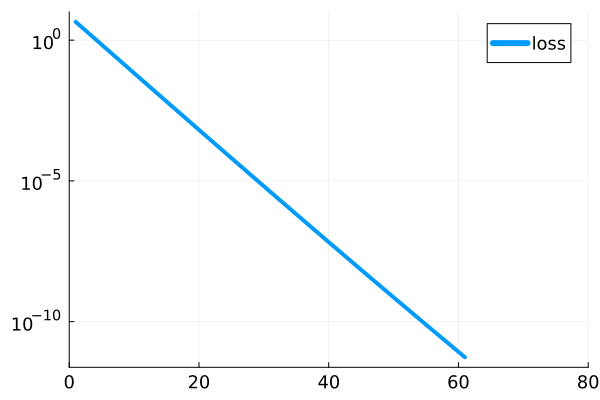

In [3]:
A = [1 1; 1 8]
@show cond(A)
loss(c) = .5 * c' * A * c
grad(c) = A * c

c, chist, lhist = grad_descent(loss, grad, [.9, .9],
    gamma=.22)
plot(lhist, yscale=:log10, xlims=(0, 80), label="loss")

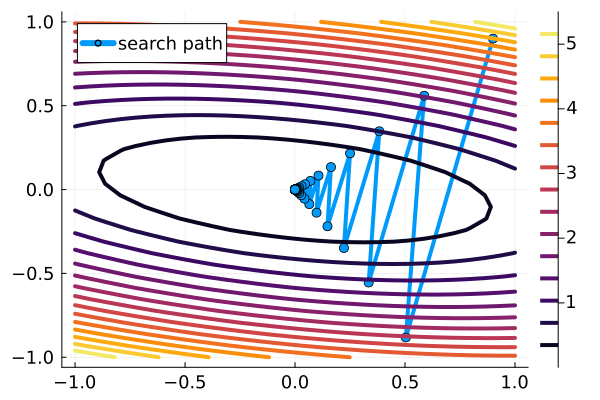

In [4]:
plot(chist[1, :], chist[2, :], marker=:circle, label="search path")
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

## Chebyshev regression via optimization

Let's try to fit our function that shows the Runge phenomenon with noise.

In [5]:
# Set up the problem to solve
x = LinRange(-1, 1, 200)
sigma = 0.5
y = runge_noisy(x, sigma)
n = 8
V = vander(x, n)

# Here's our loss function
function loss(c)
    r = V * c - y
    .5 * r' * r
end
# and our gradient
function grad(c)
    r = V * c - y
    V' * r
end

# Solve
c, _, lhist = grad_descent(loss, grad, ones(n), gamma=0.008)
# and our final coefficients are....
@show c;

c = [0.8096638690359846, 0.1201880259633985, -1.9655112466362241, -0.276364046690793, 0.3792404467883882, -0.012252679517093112, 1.1496013397244185, 0.3229991765611218]


cond(V) = 230.0054998201452
cond(V' * V) = 52902.529947850875


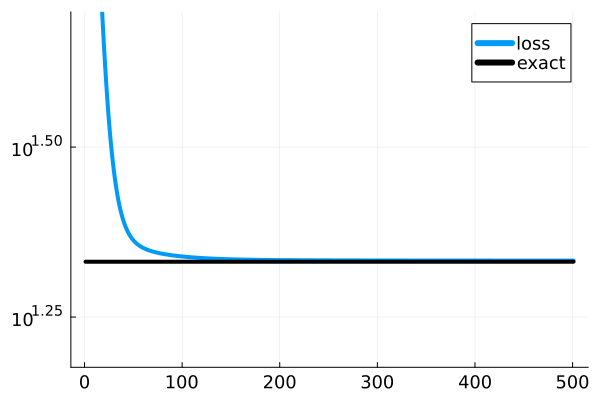

In [6]:
c0 = V \ y # Solve exactly
l0 = 0.5 * norm(V * c0 - y)^2

@show cond(V)
@show cond(V' * V)

plot(lhist, yscale=:log10, ylim=(15, 50), label="loss")
plot!(i -> l0, color=:black, label="exact")

## But why

Why would we use gradient-based optimization vs QR or other direct solves?

## Nonlinear models

Instead of the linear model

$$ f \left( x, c \right) = V \left( x \right) c = c_0 + c_1 T_1 \left( x \right) + c_2 T_2 \left( x \right) + \cdots $$

let's consider a rational model with only three parameters

$$ f \left( x, c \right) = \frac{1}{c_1 + c_2 x + c_3 x^2} = \left( c_1 + c_2 x + c_3 x^2 \right)^{-1} $$

We'll use the same loss function

$$ L \left( c; x, y \right) = \frac{1}{2} \left\lvert \left\lvert f \left( x, c \right) - y \right\rvert \right\rvert^2 $$

We will also need the gradient

$$ \nabla_c L \left( c; x, y \right) = \left( f \left( x, c \right) - y \right)^T \nabla_c f \left( x, c \right) $$

where

$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} = - f \left( x, c \right)^2 $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x = - f \left( x, c \right)^2 x $$
$$ \frac{\partial f \left( x, c \right)}{\partial c_1} = - \left( c_1 + c_2 x + c_3 x^2 \right)^{-2} x^2 = - f \left( x, c \right)^2 x^2 $$

## Fitting a rational function

Now let's fit our rational function with gradient descent, as above.

In [7]:
f(x, c) = 1 ./ (c[1] .+ c[2].*x + c[3].*x.^2)

function gradf(x, c)
    f2 = f(x, c).^2
    [-f2 -f2.*x -f2.*x.^2]
end

function loss(c)
    r = f(x, c) - y
    0.5 * r' * r
end

function gradient(c)
    r = f(x, c) - y
    vec(r' * gradf(x, c))
end

gradient (generic function with 1 method)

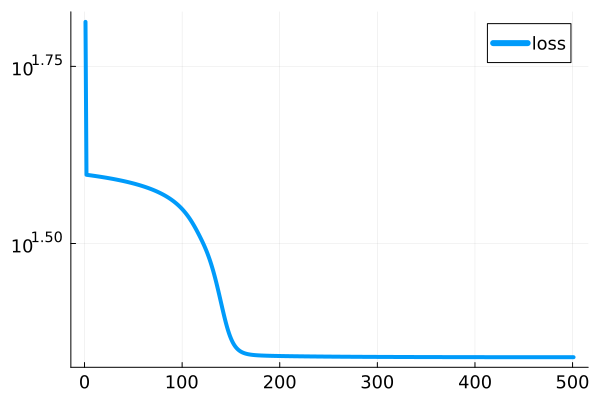

In [8]:
c, _, lhist = grad_descent(loss, gradient, ones(3), gamma=8e-2)
plot(lhist, yscale=:log10, label="loss")

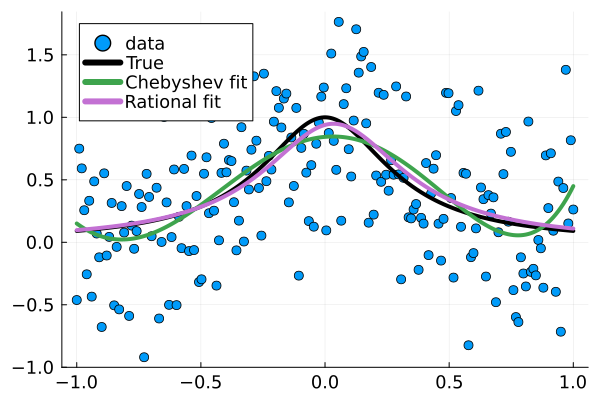

In [9]:
scatter(x, y, label="data")
V = vander_chebyshev(x, 7)
plot!(x -> runge(x), color=:black, label="True")
plot!(x, V * (V \ y), label="Chebyshev fit")
plot!(x -> f(x, c), label="Rational fit")

## Computing derivatives

How should we compute these derivatives as the model gets complicated?

Recall the definition of the derivative:

$$ \lim_{h \rightarrow 0} \frac{f \left( x + h \right) - f \left( x \right)}{h} $$

### Taylor series

Classical accuracy analysis assumes that functions are sufficiently smooth, meaning that derivatives exist and Taylor expansions are valid within a neighborhood.
In particular,

$$ f \left( x + h \right) = f \left( x \right) + f' \left( x \right) h + f'' \left( x \right) \frac{h^2}{2!} + \underbrace{f''' \left( x \right) \frac{h^3}{3!} + \dotsb}_{\mathcal{O} \left( h^3 \right)} $$

The big-$\mathcal{O}$ notation is meant in the limit $h \rightarrow 0$.
Specifically, a function $g \left( h \right) \in \mathcal{O} \left( h^p \right)$ (sometimes written as $g \left( h \right) = \mathcal{O} \left( h^p \right)$) when there exists a constant $C$ such that

$$ g \left( h \right) \leq C h^p $$

for all sufficiently *small* $h$.

### Rounding error

We have an additional source of error, *rounding error*, which comes from not being able to compute $f \left( x \right)$ or $f \left( x + h \right)$ exactly, nor subtract them exactly.
Suppose that we can, however, compute these functions with a relative error on the order of $\epsilon_\text{machine}$.
This leads to

$$ \begin{split} \begin{split}
\tilde f \left( x \right) 
  &= f \left( x \right) \left( 1 + \epsilon_1 \right) \\
\tilde f \left( x \oplus h \right)
  &= \tilde f \left( \left( x + h \right) \left( 1 + \epsilon_2 \right) \right) \\
  &= f \left( \left( x + h \right) \left( 1 + \epsilon_2 \right) \right) \left( 1 + \epsilon_3 \right) \\
  &= \left[ f \left( x + h \right) + f' \left( x + h \right) \left( x + h \right) \epsilon_2 + \\mathcal{O} \left( \epsilon_2^2 \right) \right] \left( 1 + \epsilon_3 \right) \\
  &= f \left( x + h \right) \left( 1 + \epsilon_3 \right) + f' \left( x + h \right) x \epsilon_2 + \mathcal{O} \left( \epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h \right)
\end{split} \end{split} $$

### Some tedious arithmetic

Propagating this error calculation gives

$$ \begin{split} \begin{split}
\left\lvert \frac{\tilde f \left( x + h \right) \ominus \tilde f \left( x \right)}{h} - \frac{f \left( x + h \right) - f \left( x \right)}{h} \right\rvert
  &= \left\lvert \frac{f \left( x + h \right) \left( 1 + \epsilon_3 \right) + f' \left( x + h \right) x \epsilon_2 + \mathcal{O} \left( \epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h \right) - f \left( x \right) \left( 1 + \epsilon_1 \right) - f \left( x + h \right) + f \left( x \right)}{h} \right\rvert \\
  &\le \frac{\left\lvert f \left( x + h \right) \epsilon_3 \right\rvert + \left\lvert f' \left( x + h \right) x \epsilon_2 \right\rvert + \left\lvert f \left( x \right) \epsilon_1 \right\rvert + \mathcal{O} \left( \epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}}h \right)}{h} \\
  &\le \frac{ \left( 2 \max_{\left[ x, x + h \right]} \left\lvert f \right\rvert + \max_{\left[ x, x + h \right]} \left\lvert f' x \right\rvert \right) \epsilon_{\text{machine}} + \mathcal{O} \left( \epsilon_{\text{machine}}^2 + \epsilon_{\text{machine}} h \right)}{h} \\
  &= \left( 2 \max \left\lvert f \right\rvert + \max \left\lvert f'x \right\rvert \right) \frac{\epsilon_{\text{machine}}}{h} + \mathcal{O} \left( \epsilon_{\text{machine}} \right) \\
\end{split} \end{split} $$

where we have assumed that $h \geq \epsilon_\text{machine}$.
This error becomes large (relative to $f'$ - we are concerned with relative error after all) when

* $f$ is large compared to $f'$

* $x$ is large

* $h$ is too small

### Automatic step size selection

Walker and Pernice, Dennis and Schnabel developed ways to automatically choose the step size when computing the derivative numerically.

In [10]:
# Derivative via differancing
diff(f, x; h=1e-8) = (f(x+h) - f(x)) / h

# And automatic selection of h
function diff_wp(f, x; h=1e-8)
    """Diff using Walker and Pernice (1998) choice of step"""
    h *= (1 + abs(x))
    (f(x+h) - f(x)) / h
end

# Let's try it!
x = 1000
@show diff_wp(sin, x) - cos(x);

diff_wp(sin, x) - cos(x) = -4.139506408429305e-6


## Symbolic differentiation

We can also use a package to symbolically differentiate like we would by hand.

In [11]:
using Pkg
pkg"add Symbolics"
using Symbolics

# Some setup
@variables x
Dx = Differential(x)

# And an example
y = sin(x)
Dx(y)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Differential(x)(sin(x))

### Product rule

This package can follow the product rule!

In [12]:
y = x
for _ in 1:2
    y = cos(y^π) * log(y)
end

# This will be... a lot
expand_derivatives(Dx(y))

((cos(x^π) / x - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))) / (log(x)*cos(x^π)) - ((3.141592653589793(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793)) / x - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*sin(x^π)*(cos(x^π)^2.141592653589793))*log(log(x)*cos(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))

The size of these expressions can grow **exponentially**!

## Hand-coded derivatives

With (mild) algebra abuse, the expression

$$ \frac{df}{dx} = f' \left( x \right) $$

is equivalent to

$$ df = f' \left( x \right) dx $$

In [13]:
function f(x)
    y = x
    for _ in 1:2
        a = y^π
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), diff_wp(f, 1.9)

(-1.5346823414986814, -34.032439961925064)

In [14]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^π
        da = π * y^(π - 1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = dy / y
        y = b * c
        dy = db * c + b * dc
    end
    y, dy
end

df(1.9, 1)

(-1.5346823414986814, -34.032419599140475)

### Forward vs reverse mode

We can differentiate a composition $h \left( g \left( f \left( x \right) \right) \right)$ as

$$ \begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x
\end{align}$$

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname{d} h = \frac{dh}{dg} \left( \frac{dg}{df} \left( \frac{df}{dx} \operatorname{d} x \right) \right) $$

This expression means the same thing if we rearrange the parenthesis,

$$ \operatorname{d} h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname{d} x $$

## Automatic differentiation

There are packages to do this differentiation 'automatically' on the code itself.

In [15]:
using Pkg
pkg"add Zygote"
import Zygote

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [16]:
Zygote.gradient(f, 1.9)

(-34.03241959914049,)

In [17]:
g(x) = exp(x) + x^2
@code_llvm Zygote.gradient(g, 1.9)

; Function Signature: gradient(typeof(Main.g), Float64)
;  @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:152 within `gradient`
define [1 x double] @julia_gradient_39389(double %"args[1]::Float64") #0 {
top:
;  @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:153 within `gradient`
; ┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:94 within `pullback` @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface.jl:96
; │┌ @ In[17]:1 within `g`
; ││┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface2.jl:81 within `_pullback`
; │││┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/interface2.jl within `macro expansion`
; ││││┌ @ /home/jeremy/.julia/packages/Zygote/55SqB/src/compiler/chainrules.jl:234 within `chain_rrule`
; │││││┌ @ /home/jeremy/.julia/packages/ChainRulesCore/Vsbj9/src/rules.jl:138 within `rrule` @ /home/jeremy/.julia/packages/ChainRules/14CDN/src/rulesets/Base/fastmath_able.